In [1]:
import torch
import pandas as pd
import astropy as ap
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
# from astropy.io import fits
import pdb
from scipy.ndimage.filters import maximum_filter1d
import glob
import fitsio as fits
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.distributions.normal import Normal
from tqdm import tqdm
from loading import TessDataset

In [2]:
from ode_rnn import create_ODERNN_model

In [3]:
import sys
sys.path.insert(0, '../')
sys.path.insert(1, '../latent_ode/')
import latent_ode.lib as ode
import latent_ode.lib.utils as utils
from latent_ode.lib.latent_ode import LatentODE
from latent_ode.lib.ode_rnn import ODE_RNN
from latent_ode.lib.encoder_decoder import Encoder_z0_ODE_RNN, Decoder
from latent_ode.lib.diffeq_solver import DiffeqSolver
from latent_ode.lib.ode_func import ODEFunc

### Loading

In [4]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [5]:
input_dim = 2
n_labels = 1
status_properties = ['loss', 'ratio']
latent_dim = 40

In [6]:
model = create_ODERNN_model()

In [7]:
model_file = 'ode_rnn_state_gaia2d.pth.tar'

In [8]:
state = torch.load(model_file, map_location=torch.device('cpu'))

In [9]:
model.load_state_dict(state['state_dict'])
model.to(device)

ODE_RNN(
  (ode_gru): Encoder_z0_ODE_RNN(
    (GRU_update): GRU_unit(
      (update_gate): Sequential(
        (0): Linear(in_features=84, out_features=50, bias=True)
        (1): Tanh()
        (2): Linear(in_features=50, out_features=40, bias=True)
        (3): Sigmoid()
      )
      (reset_gate): Sequential(
        (0): Linear(in_features=84, out_features=50, bias=True)
        (1): Tanh()
        (2): Linear(in_features=50, out_features=40, bias=True)
        (3): Sigmoid()
      )
      (new_state_net): Sequential(
        (0): Linear(in_features=84, out_features=50, bias=True)
        (1): Tanh()
        (2): Linear(in_features=50, out_features=80, bias=True)
      )
    )
    (z0_diffeq_solver): DiffeqSolver(
      (ode_func): ODEFunc(
        (gradient_net): Sequential(
          (0): Linear(in_features=40, out_features=100, bias=True)
          (1): Tanh()
          (2): Linear(in_features=100, out_features=100, bias=True)
          (3): Tanh()
          (4): Linear(in_featu

In [10]:
model.eval()

ODE_RNN(
  (ode_gru): Encoder_z0_ODE_RNN(
    (GRU_update): GRU_unit(
      (update_gate): Sequential(
        (0): Linear(in_features=84, out_features=50, bias=True)
        (1): Tanh()
        (2): Linear(in_features=50, out_features=40, bias=True)
        (3): Sigmoid()
      )
      (reset_gate): Sequential(
        (0): Linear(in_features=84, out_features=50, bias=True)
        (1): Tanh()
        (2): Linear(in_features=50, out_features=40, bias=True)
        (3): Sigmoid()
      )
      (new_state_net): Sequential(
        (0): Linear(in_features=84, out_features=50, bias=True)
        (1): Tanh()
        (2): Linear(in_features=50, out_features=80, bias=True)
      )
    )
    (z0_diffeq_solver): DiffeqSolver(
      (ode_func): ODEFunc(
        (gradient_net): Sequential(
          (0): Linear(in_features=40, out_features=100, bias=True)
          (1): Tanh()
          (2): Linear(in_features=100, out_features=100, bias=True)
          (3): Tanh()
          (4): Linear(in_featu

### Plot Multiple

In [11]:
loader = torch.load('gaia2d_train.pt')

In [12]:
batch = next(iter(loader))

In [29]:
ix = 17

In [30]:
observed = batch['observed_data'][ix].unsqueeze(0).to(device)
true = batch['data_to_predict'][ix].unsqueeze(0).to(device)
mask = batch['observed_mask'][ix].unsqueeze(0).to(device)
t = batch['observed_tp'].to(device)

In [31]:
m = mask.squeeze()

In [32]:
cmeas = (m != 0).any(1)

In [33]:
t_ix = t[cmeas]

In [34]:
a = t_ix.min().item()
b = t_ix.max().item()
step = (b-a)/50
t_pred=torch.arange(a,b,step)#.detach().cpu().numpy()

In [35]:
rec = model.get_reconstruction(
    time_steps_to_predict=t, 
    data=observed, 
    truth_time_steps=t, 
    mask=mask, 
    n_traj_samples=20)[0].detach().cpu().squeeze()

In [36]:
rec = rec.detach().cpu().numpy()
truth = true.detach().squeeze().cpu().numpy()
obs = observed.squeeze().detach().cpu().numpy()

In [37]:
rec1 = rec[:,0]
rec2 = rec[:,1]

In [38]:
c1 = (obs[:,0] != 0)
c2 = (obs[:,1] != 0)

In [39]:
obs1 = obs[c1][:,0]
obs2 = obs[c2][:,1]
t1 = t[c1].detach().cpu().numpy()
t2 = t[c2].detach().cpu().numpy()

In [40]:
plt.style.use('seaborn-darkgrid')
font = {'family': 'serif',
        'color':  'grey',
        'weight': 'light',
        'size': 12,
        }

In [41]:
t0 = t1.min()

In [42]:
g = t>t0

In [43]:
t_ix.shape

torch.Size([15])

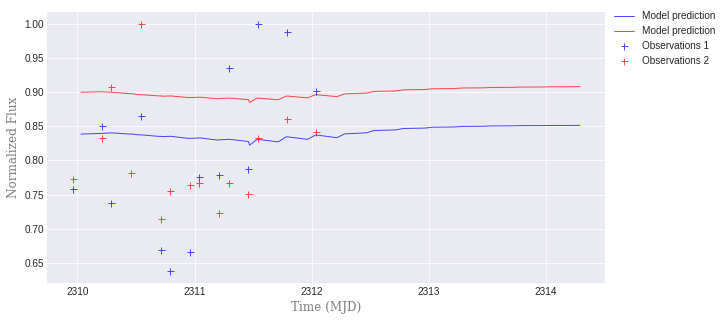

In [44]:
plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.plot(t[g], rec1[g], marker='', color='blue', linewidth=1, alpha=0.7, label='Model prediction')
ax.plot(t[g], rec2[g], marker='', color='red', linewidth=1, alpha=0.7, label='Model prediction')
ax.plot(t1, obs1, marker='+', color='blue', linestyle='None', alpha=0.7, markersize=7, label='Observations 1')
ax.plot(t2, obs2, marker='+', color='red', linestyle='None', alpha=0.7, markersize=7, label='Observations 2')
plt.xlabel("Time (MJD)", fontdict=font)
plt.ylabel("Normalized Flux", fontdict=font)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.9),
          ncol=1, fancybox=True, shadow=True)
# ax.tick_params(
#     axis='both',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False,
#     labelleft=False,
#     right=False, 
#     left=False)